In [1]:
# Add the directory to sys.path
import sys
sys.path.append('/scratch/project_2010376')

2024-08-23 15:44:39.147690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 15:44:39.162637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 15:44:39.182015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 15:44:39.182032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 15:44:39.195280: I tensorflow/core/platform/cpu_feature_gua

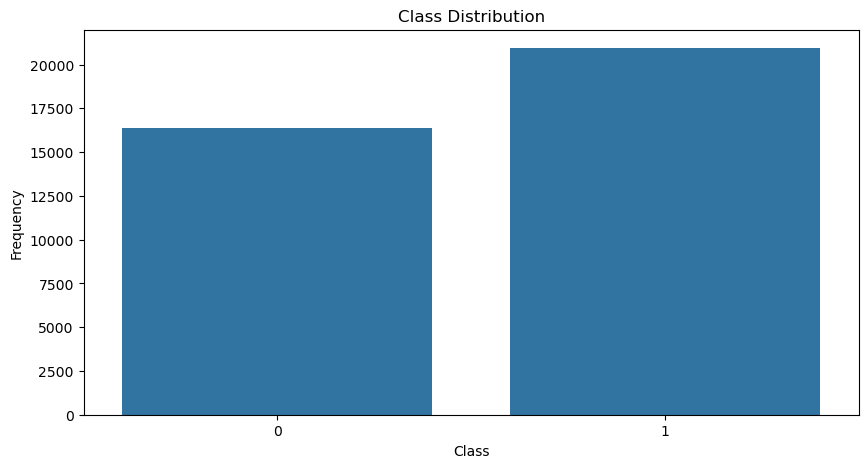

Features for non-persister (class 0) saved to 'cnn_rnn_non_persister_features.txt'
Features for persister (class 1) saved to 'cnn_rnn_persister_features.txt'


/scratch/project_2010376/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-23 16:32:08.121455: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.6548 - loss: 0.9170 - val_accuracy: 0.4974 - val_loss: 1.3134 - learning_rate: 1.0000e-04
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9606 - loss: 0.3254 - val_accuracy: 0.6877 - val_loss: 0.8067 - learning_rate: 1.0000e-04
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9851 - loss: 0.2107 - val_accuracy: 0.4983 - val_loss: 1.9846 - learning_rate: 1.0000e-04
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9901 - loss: 0.1737 - val_accuracy: 0.4983 - val_loss: 1.2863 - learning_rate: 1.0000e-04
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9912 - loss: 0.1543 - val_accuracy: 0.5017 - val_loss: 0.8607 - learning_rate: 1.0000e-04
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9950 - loss: 0.1256 - val_accuracy: 0.5026 - val_loss: 0.7812 - learning_rate: 1.0000e-04
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 26s 5

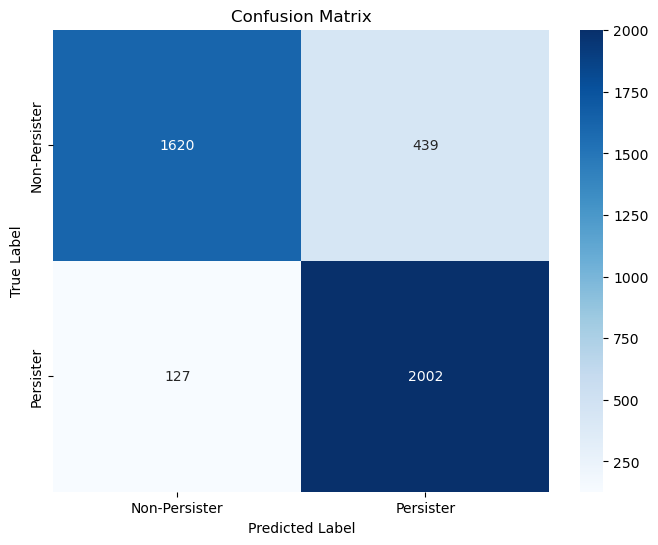

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Function to load data in chunks
def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

# Preprocessing function with labeling and merging
def preprocess_data(metadata_path, data_path, additional_datasets=None):
    # Load metadata and main scRNA-seq data
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    # Process the 'cell' column in both metadata and scRNA data
    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Filter based on common cells
    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))
    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    # Label 'sample_type' in metadata
    non_persister_samples = ["0"]
    persister_samples = ["7", "3", "14_high", "14_med", "14_low"]

    filtered_metadata_df['sample_type'] = filtered_metadata_df['sample_type'].apply(
        lambda x: 'Non-Persister' if str(x) in non_persister_samples else 'Persister'
    )

    # Merge metadata and scRNA data
    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')

    # Include additional datasets and assign labels directly
    if additional_datasets:
        for file_path, label in additional_datasets:
            additional_data = pd.concat(load_data_in_chunks(file_path)).transpose()
            additional_data.reset_index(inplace=True)
            additional_data.rename(columns={'index': 'cell'}, inplace=True)
            additional_data['cell'] = additional_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
            additional_data['sample_type'] = label  # Directly assigning the label
            merged_data = pd.concat([merged_data, additional_data], ignore_index=True, sort=False)

    gene_names = merged_data.columns[1:-2]  # Assuming the first column is 'cell', and last two are 'sample_name' and 'sample_type'

    # Preparing the input features and labels
    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X.columns = X.columns.astype(str)
    X = X.apply(pd.to_numeric, errors='coerce')

    # Imputation of missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Encode labels
    y = merged_data['sample_type'].apply(lambda x: 1 if x == 'Persister' else 0).values

    return X, y, merged_data, gene_names

# CNN-RNN Hybrid Model with stronger regularization
def create_cnn_rnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        LSTM(64, kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 5:  # Start reducing learning rate earlier
        lr = lr * 0.85
    return lr

# Main Code Execution
metadata_path = '/scratch/project_2010376/GSE150949_metaData_with_lineage.txt'
data_path = '/scratch/project_2010376/normalized_GSE150949_pc9_count.csv'
additional_datasets = [
    ('/scratch/project_2010751/GSM8118468_ob_treated.csv', 'Persister'),
    ('/scratch/project_2010751/GSE134836_GSM3972651_PC9D0_untreated_filtered.csv', 'Non-Persister'),
    ('/scratch/project_2010751/GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv', 'Non-Persister'),
    ('/scratch/project_2010751/GSE134839_GSM3972657_PC90D0_untreated.dge.csv', 'Non-Persister')
]

# Preprocess the data
X, y, merged_data, gene_names = preprocess_data(metadata_path, data_path, additional_datasets)

# Confirm class 0 is non-persister and class 1 is persister
class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reduced, y)

# Extract features for non-persister (class 0) and persister (class 1)
non_persister_features = X_resampled[y_resampled == 0]
persister_features = X_resampled[y_resampled == 1]

# Ensure all gene names are strings
gene_names = [str(gene) for gene in gene_names]

# Save the features to text files with gene names as headers
np.savetxt('cnn_rnn_non_persister_features.txt', non_persister_features, delimiter=',', header=','.join(gene_names), fmt='%.6f', comments='')
np.savetxt('cnn_rnn_persister_features.txt', persister_features, delimiter=',', header=','.join(gene_names), fmt='%.6f', comments='')

print("Features for non-persister (class 0) saved to 'cnn_rnn_non_persister_features.txt'")
print("Features for persister (class 1) saved to 'cnn_rnn_persister_features.txt'")

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fix input shape by making it a tuple
input_shape = (X_train.shape[1], 1)

# Train the CNN-RNN model
model = create_cnn_rnn_model(input_shape)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_rnn_model.keras', save_best_only=True, monitor='val_loss', mode='min')
lr_schedule = LearningRateScheduler(lr_scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Model training
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    epochs=100, batch_size=64, class_weight=class_weight_dict,
                    callbacks=[early_stopping, model_checkpoint, lr_schedule, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Persister', 'Persister'], yticklabels=['Non-Persister', 'Persister'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the final model
model.save('final_cnn_rnn_model_v2.0.keras')



In [ ]:
import json
from datetime import datetime

# Function to generate JSON-LD metadata
def generate_jsonld_metadata(merged_data, model, pca_components, model_path):
    metadata = {
        "@context": "https://schema.org/",
        "@type": "Dataset",
        "name": "Persister Cell Prediction Dataset",
        "description": "This dataset contains harmonized scRNA-seq data for predicting persister vs. non-persister cancer cells using CNN-RNN.",
        "datePublished": datetime.now().strftime("%Y-%m-%d"),
        "creator": {
            "@type": "Person",
            "name": "Jyotidip Barman",
            "affiliation": {
                "@type": "Organization",
                "name": "University of Helsinki"
            }
        },
        "license": "TBD",
        "measurementTechnique": "Single-cell RNA sequencing (scRNA-seq)",
        "variableMeasured": [str(col) for col in merged_data.columns if col not in ['cell', 'sample_name', 'sample_type']],
        "identifier": "TBD",
        "keywords": [
            "Persister cells",
            "Cancer research",
            "scRNA-seq",
            "Machine learning",
            "Deep learning",
            "CNN-RNN",
            "PCA",
            "SMOTE",
            "FAIR data"
        ],
        "distribution": [
            {
                "@type": "DataDownload",
                "contentUrl": model_path,
                "encodingFormat": "application/vnd.keras"
            }
        ],
        "additionalProperty": [
            {
                "@type": "PropertyValue",
                "name": "PCA Components",
                "value": pca_components
            },
            {
                "@type": "PropertyValue",
                "name": "Model Type",
                "value": "CNN-RNN hybrid (Conv1D + LSTM)"
            },
            {
                "@type": "PropertyValue",
                "name": "Accuracy",
                "value": model.evaluate(X_test, y_test, verbose=0)[1]
            }
        ]
    }

    with open("cnn_rnn_metadata.jsonld", "w") as jsonld_file:
        json.dump(metadata, jsonld_file, indent=2)

    print("JSON-LD metadata generated and saved to cnn_rnn_metadata.jsonld")


In [ ]:
# Existing line to save model
model.save('final_cnn_rnn_model_v2.0.keras')

# Generate JSON-LD metadata after saving the model
generate_jsonld_metadata(merged_data, model, pca.n_components, 'final_cnn_rnn_model_v2.0.keras')


In [3]:
# Function to preprocess independent datasets
def preprocess_independent_data(file_path, train_columns, n_components):
    independent_data = pd.concat(load_data_in_chunks(file_path)).transpose()
    independent_data.reset_index(inplace=True)
    independent_data.rename(columns={'index': 'cell'}, inplace=True)

    if independent_data.shape[0] > independent_data.shape[1]:
        independent_data = independent_data.transpose()

    X_independent = independent_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X_independent.columns = X_independent.columns.astype(str)
    train_columns = train_columns.astype(str)

    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)
    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')
    X_independent.fillna(0, inplace=True)

    pca = PCA(n_components=n_components)
    X_independent = pca.fit_transform(X_independent)
    
    return X_independent

# Function to predict on independent datasets
def predict_independent_dataset(model, file_path, train_columns, n_components):
    try:
        X_independent = preprocess_independent_data(file_path, train_columns, n_components)
        X_independent = X_independent.reshape(X_independent.shape[0], X_independent.shape[1], 1)
        predictions = model.predict(X_independent)
        predicted_labels = (predictions > 0.5).astype(int)
        counts = Counter(predicted_labels.flatten())
        return counts
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return Counter()

# Load the trained model
model = tf.keras.models.load_model('final_cnn_rnn_model_v2.0.keras')

# Get the feature columns from merged_data used in training
train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type']).columns  # Exclude the target column

# Use the same number of PCA components as used in the model
n_components = model.input_shape[1]

# Independent datasets
independent_datasets = {
    "GSE134836_GSM3972651_PC9D0_untreated_filtered.csv": "/scratch/project_2010751/GSE134836_GSM3972651_PC9D0_untreated_filtered.csv",
    "GSM4869650_xCtrl": "/scratch/project_2010376/GSM4869650_xCtrl.dge.csv",
    "new_GSM4869650_xCtrl.dge.csv": "/scratch/project_2010376/new_GSM4869650_xCtrl.dge.csv",
    "GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv": "/scratch/project_2010751/GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv",
    "GSM4869653_xOsiCriz":"/scratch/project_2010751/GSE134839_GSM3972657_PC90D0_untreated.dge.csv",
    "GSE149383_GSM3972669_D0_untreated.dge.csv":"/scratch/project_2010751/GSE149383_GSM3972669_D0_untreated.dge.csv",
    "GSE160244_GSM4869650_day3_untreated.dge.csv":"/scratch/project_2010751/GSE160244_GSM4869650_day3_untreated.dge.csv",
    "GSE160244_GSM4869652_xOsi_day3_dge.csv":"/scratch/project_2010751/GSE160244_GSM4869652_xOsi_day3_dge.csv",
    "normalized_GSE150949_pc9_count.csv":"/scratch/project_2010751/normalized_GSE150949_pc9_count.csv",
    "GSE150949_pc9_count_matrix.csv": "/scratch/project_2010376/GSE150949_pc9_count_matrix.csv"
}

# Process each independent dataset and make predictions
results = {}
for dataset_name, file_path in independent_datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    counts = predict_independent_dataset(model, file_path, train_columns, n_components)
    results[f"Transfer Learning - {dataset_name}"] = counts
    print(f"{dataset_name} - Transfer Learning Predictions: {counts}")

# Print final results
print("\nFinal Prediction Results:")
for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")



Processing dataset: GSE134836_GSM3972651_PC9D0_untreated_filtered.csv
395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
GSE134836_GSM3972651_PC9D0_untreated_filtered.csv - Transfer Learning Predictions: Counter({0: 9679, 1: 2945})

Processing dataset: GSM4869650_xCtrl
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
GSM4869650_xCtrl - Transfer Learning Predictions: Counter({0: 3776, 1: 892})

Processing dataset: new_GSM4869650_xCtrl.dge.csv
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
new_GSM4869650_xCtrl.dge.csv - Transfer Learning Predictions: Counter({0: 3787, 1: 881})

Processing dataset: GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv - Transfer Learning Predictions: Counter({0: 1274})

Processing dataset: GSM4869653_xOsiCriz
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
GSM4869653_xOsiCriz - Transfer Learning Predictions: Counter({0: 2407, 1: 87})

Processing dataset: GSE149383_GSM3972669_D0_

In [3]:
import os
import tensorflow as tf
from collections import Counter

# Function to load and inspect the data for correct orientation
def load_and_inspect_data(file_path):
    # Load a small chunk of data to determine orientation
    small_chunk = pd.read_csv(file_path, nrows=5, engine='python', encoding='utf-8')

    # Determine if genes are in rows or columns
    if small_chunk.shape[0] > small_chunk.shape[1]:
        data_orientation = "genes_in_rows"
    else:
        data_orientation = "genes_in_columns"
    
    # Load the entire dataset
    data = pd.concat(load_data_in_chunks(file_path)).transpose() if data_orientation == "genes_in_columns" else pd.concat(load_data_in_chunks(file_path))
    
    return data, data_orientation

# Function to preprocess independent datasets
def preprocess_independent_data(file_path, train_columns, n_components):
    # Load and inspect the data to determine its orientation
    independent_data, data_orientation = load_and_inspect_data(file_path)
    independent_data.reset_index(inplace=True)
    
    if data_orientation == "genes_in_columns":
        independent_data.rename(columns={'index': 'cell'}, inplace=True)
    else:
        independent_data.rename(columns={0: 'cell'}, inplace=True)
    
    X_independent = independent_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X_independent.columns = X_independent.columns.astype(str)
    train_columns = train_columns.astype(str)

    # Ensure the independent data matches the training data columns
    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)
    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')
    X_independent.fillna(0, inplace=True)

    pca = PCA(n_components=n_components)
    X_independent = pca.fit_transform(X_independent)
    
    return X_independent

# Function to predict on independent datasets
def predict_independent_dataset(model, file_path, train_columns, n_components):
    try:
        X_independent = preprocess_independent_data(file_path, train_columns, n_components)
        X_independent = X_independent.reshape(X_independent.shape[0], X_independent.shape[1], 1)
        predictions = model.predict(X_independent)
        predicted_labels = (predictions > 0.5).astype(int)
        counts = Counter(predicted_labels.flatten())
        return counts
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return Counter()

# Load the trained model
model = tf.keras.models.load_model('final_cnn_rnn_model_v2.0.keras')

# Get the feature columns from merged_data used in training
train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type']).columns  # Exclude the target column

# Use the same number of PCA components as used in the model
n_components = model.input_shape[1]

# Directory containing the independent datasets
independent_datasets_dir = "/scratch/project_2010751/GSE123902_RAW/"

# Iterate over all non-gz files in the directory
results = {}
for file_name in os.listdir(independent_datasets_dir):
    file_path = os.path.join(independent_datasets_dir, file_name)
    
    if not file_name.endswith('.gz') and os.path.isfile(file_path):
        print(f"\nProcessing dataset: {file_name}")
        counts = predict_independent_dataset(model, file_path, train_columns, n_components)
        results[f"Transfer Learning - {file_name}"] = counts
        print(f"{file_name} - Transfer Learning Predictions: {counts}")

# Print final results
print("\nFinal Prediction Results:")
for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")



Processing dataset: GSM3516667_MSK_LX676_PRIMARY_TUMOUR_dense.csv
566/566 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step
GSM3516667_MSK_LX676_PRIMARY_TUMOUR_dense.csv - Transfer Learning Predictions: Counter({1: 18063, 0: 20})

Processing dataset: GSM3516668_MSK_LX255B_METASTASIS_dense.csv
509/509 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
GSM3516668_MSK_LX255B_METASTASIS_dense.csv - Transfer Learning Predictions: Counter({1: 16288})

Processing dataset: GSM3516666_MSK_LX675_NORMAL_dense.csv
568/568 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
GSM3516666_MSK_LX675_NORMAL_dense.csv - Transfer Learning Predictions: Counter({1: 18124, 0: 35})

Processing dataset: GSE123902_series_matrix.txt
Error processing /scratch/project_2010751/GSE123902_RAW/GSE123902_series_matrix.txt: ',' expected after '"'
GSE123902_series_matrix.txt - Transfer Learning Predictions: Counter()

Processing dataset: GSM3516675_MSK_LX684_NORMAL_dense.csv
554/554 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
GSM3516675_MSK_LX684_NORMAL_dense.csv - Transfer Learn

In [9]:
import os
import tensorflow as tf
from collections import Counter

# Function to load and inspect the data for correct orientation
def load_and_inspect_data(file_path):
    # Load a small chunk of data to determine orientation
    small_chunk = pd.read_csv(file_path, nrows=5, engine='python', encoding='utf-8')

    # Determine if genes are in rows or columns
    if small_chunk.shape[0] > small_chunk.shape[1]:
        data_orientation = "genes_in_rows"
    else:
        data_orientation = "genes_in_columns"
    
    # Load the entire dataset
    data = pd.concat(load_data_in_chunks(file_path)).transpose() if data_orientation == "genes_in_columns" else pd.concat(load_data_in_chunks(file_path))
    
    return data, data_orientation

# Function to preprocess independent datasets
def preprocess_independent_data(file_path, train_columns, n_components):
    # Load and inspect the data to determine its orientation
    independent_data, data_orientation = load_and_inspect_data(file_path)
    independent_data.reset_index(inplace=True)
    
    if data_orientation == "genes_in_columns":
        independent_data.rename(columns={'index': 'cell'}, inplace=True)
    else:
        independent_data.rename(columns={0: 'cell'}, inplace=True)
    
    X_independent = independent_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X_independent.columns = X_independent.columns.astype(str)
    train_columns = train_columns.astype(str)

    # Ensure the independent data matches the training data columns
    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)
    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')
    X_independent.fillna(0, inplace=True)

    pca = PCA(n_components=n_components)
    X_independent = pca.fit_transform(X_independent)
    
    return X_independent

# Function to predict on independent datasets
def predict_independent_dataset(model, file_path, train_columns, n_components):
    try:
        X_independent = preprocess_independent_data(file_path, train_columns, n_components)
        X_independent = X_independent.reshape(X_independent.shape[0], X_independent.shape[1], 1)
        predictions = model.predict(X_independent)
        predicted_labels = (predictions > 0.5).astype(int)
        counts = Counter(predicted_labels.flatten())
        return counts
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return Counter()

# Load the trained model
model = tf.keras.models.load_model('final_cnn_rnn_model.keras')

# Get the feature columns from merged_data used in training
train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type']).columns  # Exclude the target column

# Use the same number of PCA components as used in the model
n_components = model.input_shape[1]

# Directory containing the independent datasets
independent_datasets_dir = "/scratch/project_2010751/GSE123902_RAW/"

# Iterate over all non-gz files in the directory
results = {}
for file_name in os.listdir(independent_datasets_dir):
    file_path = os.path.join(independent_datasets_dir, file_name)
    
    if not file_name.endswith('.gz') and os.path.isfile(file_path):
        print(f"\nProcessing dataset: {file_name}")
        counts = predict_independent_dataset(model, file_path, train_columns, n_components)
        results[f"Transfer Learning - {file_name}"] = counts
        print(f"{file_name} - Transfer Learning Predictions: {counts}")

# Print final results
print("\nFinal Prediction Results:")
for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")



Processing dataset: GSM3516667_MSK_LX676_PRIMARY_TUMOUR_dense.csv
566/566 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
GSM3516667_MSK_LX676_PRIMARY_TUMOUR_dense.csv - Transfer Learning Predictions: Counter({1: 17957, 0: 126})

Processing dataset: GSM3516668_MSK_LX255B_METASTASIS_dense.csv
509/509 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
GSM3516668_MSK_LX255B_METASTASIS_dense.csv - Transfer Learning Predictions: Counter({1: 16271, 0: 17})

Processing dataset: GSM3516666_MSK_LX675_NORMAL_dense.csv
568/568 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
GSM3516666_MSK_LX675_NORMAL_dense.csv - Transfer Learning Predictions: Counter({1: 18012, 0: 147})

Processing dataset: GSE123902_series_matrix.txt
Error processing /scratch/project_2010751/GSE123902_RAW/GSE123902_series_matrix.txt: ',' expected after '"'
GSE123902_series_matrix.txt - Transfer Learning Predictions: Counter()

Processing dataset: GSM3516675_MSK_LX684_NORMAL_dense.csv
554/554 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
GSM3516675_MSK_LX684_NORMAL_dense.csv - Transf

In [12]:
# Function to preprocess independent datasets
def preprocess_independent_data(file_path, train_columns, n_components):
    independent_data = pd.concat(load_data_in_chunks(file_path)).transpose()
    independent_data.reset_index(inplace=True)
    independent_data.rename(columns={'index': 'cell'}, inplace=True)

    if independent_data.shape[0] > independent_data.shape[1]:
        independent_data = independent_data.transpose()

    X_independent = independent_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X_independent.columns = X_independent.columns.astype(str)
    train_columns = train_columns.astype(str)

    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)
    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')
    X_independent.fillna(0, inplace=True)

    pca = PCA(n_components=n_components)
    X_independent = pca.fit_transform(X_independent)
    
    return X_independent

# Function to predict on independent datasets
def predict_independent_dataset(model, file_path, train_columns, n_components):
    try:
        X_independent = preprocess_independent_data(file_path, train_columns, n_components)
        X_independent = X_independent.reshape(X_independent.shape[0], X_independent.shape[1], 1)
        predictions = model.predict(X_independent)
        predicted_labels = (predictions > 0.5).astype(int)
        counts = Counter(predicted_labels.flatten())
        return counts
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return Counter()

# Load the trained model
model = tf.keras.models.load_model('final_cnn_rnn_model_v2.0.keras')

# Get the feature columns from merged_data used in training
train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type']).columns  # Exclude the target column

# Use the same number of PCA components as used in the model
n_components = model.input_shape[1]

# Independent datasets
independent_datasets = {
    "GSE134836_GSM3972651_PC9D0_untreated_filtered.csv": "/scratch/project_2010751/GSE134836_GSM3972651_PC9D0_untreated_filtered.csv",
    "GSM4869650_xCtrl": "/scratch/project_2010376/GSM4869650_xCtrl.dge.csv",
    "new_GSM4869650_xCtrl.dge.csv": "/scratch/project_2010376/new_GSM4869650_xCtrl.dge.csv",
    "GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv": "/scratch/project_2010751/GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv",
    "GSM4869653_xOsiCriz":"/scratch/project_2010751/GSE134839_GSM3972657_PC90D0_untreated.dge.csv",
    "GSE149383_GSM3972669_D0_untreated.dge.csv":"/scratch/project_2010751/GSE149383_GSM3972669_D0_untreated.dge.csv",
    "GSE160244_GSM4869650_day3_untreated.dge.csv":"/scratch/project_2010751/GSE160244_GSM4869650_day3_untreated.dge.csv",
    "GSE160244_GSM4869652_xOsi_day3_dge.csv":"/scratch/project_2010751/GSE160244_GSM4869652_xOsi_day3_dge.csv",
    "normalized_GSE150949_pc9_count.csv":"/scratch/project_2010751/normalized_GSE150949_pc9_count.csv",
    "GSE150949_pc9_count_matrix.csv": "/scratch/project_2010376/GSE150949_pc9_count_matrix.csv"
}

# Process each independent dataset and make predictions
results = {}
for dataset_name, file_path in independent_datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    counts = predict_independent_dataset(model, file_path, train_columns, n_components)
    results[f"Transfer Learning - {dataset_name}"] = counts
    print(f"{dataset_name} - Transfer Learning Predictions: {counts}")

# Print final results
print("\nFinal Prediction Results:")
for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")



Processing dataset: GSE134836_GSM3972651_PC9D0_untreated_filtered.csv
395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
GSE134836_GSM3972651_PC9D0_untreated_filtered.csv - Transfer Learning Predictions: Counter({0: 11435, 1: 1189})

Processing dataset: GSM4869650_xCtrl
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
GSM4869650_xCtrl - Transfer Learning Predictions: Counter({0: 4171, 1: 497})

Processing dataset: new_GSM4869650_xCtrl.dge.csv
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
new_GSM4869650_xCtrl.dge.csv - Transfer Learning Predictions: Counter({0: 4174, 1: 494})

Processing dataset: GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv - Transfer Learning Predictions: Counter({0: 1273, 1: 1})

Processing dataset: GSM4869653_xOsiCriz
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
GSM4869653_xOsiCriz - Transfer Learning Predictions: Counter({1: 2429, 0: 65})

Processing dataset: GSE149383_GSM3972

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 49, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,629 (1.75 MB)

 Trainable params: 152,833 (597.00 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 305,668 (1.17 MB)

In [15]:
# Function to preprocess independent datasets
def preprocess_independent_data(file_path, train_columns, n_components):
    independent_data = pd.concat(load_data_in_chunks(file_path)).transpose()
    independent_data.reset_index(inplace=True)
    independent_data.rename(columns={'index': 'cell'}, inplace=True)

    if independent_data.shape[0] > independent_data.shape[1]:
        independent_data = independent_data.transpose()

    X_independent = independent_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X_independent.columns = X_independent.columns.astype(str)
    train_columns = train_columns.astype(str)

    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)
    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')
    X_independent.fillna(0, inplace=True)

    pca = PCA(n_components=n_components)
    X_independent = pca.fit_transform(X_independent)
    
    return X_independent

# Function to predict on independent datasets
def predict_independent_dataset(model, file_path, train_columns, n_components):
    try:
        X_independent = preprocess_independent_data(file_path, train_columns, n_components)
        X_independent = X_independent.reshape(X_independent.shape[0], X_independent.shape[1], 1)
        predictions = model.predict(X_independent)
        predicted_labels = (predictions > 0.5).astype(int)
        counts = Counter(predicted_labels.flatten())
        return counts
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return Counter()

# Load the trained model
model = tf.keras.models.load_model('final_cnn_rnn_model_v2.0.keras')

# Get the feature columns from merged_data used in training
train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type']).columns  # Exclude the target column

# Use the same number of PCA components as used in the model
n_components = model.input_shape[1]

# Independent datasets
independent_datasets = {
    "GSM7791001_normalized.csv": "/scratch/project_2010751/GSM7791001_normalized.csv",
    "GSM7791000_normalized.csv": "/scratch/project_2010751/GSM7791000_normalized.csv",
    "GSM7790999_320_normalized.csv": "/scratch/project_2010751/GSM7790999_320_normalized.csv",
    "GSM7790998_387_normalized.csv": "/scratch/project_2010751/GSM7790998_387_normalized.csv"
}

# Process each independent dataset and make predictions
results = {}
for dataset_name, file_path in independent_datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    counts = predict_independent_dataset(model, file_path, train_columns, n_components)
    results[f"Transfer Learning - {dataset_name}"] = counts
    print(f"{dataset_name} - Transfer Learning Predictions: {counts}")

# Print final results
print("\nFinal Prediction Results:")
for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")



Processing dataset: GSM7791001_normalized.csv
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
GSM7791001_normalized.csv - Transfer Learning Predictions: Counter({1: 1836, 0: 706})

Processing dataset: GSM7791000_normalized.csv
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
GSM7791000_normalized.csv - Transfer Learning Predictions: Counter({1: 3810, 0: 2888})

Processing dataset: GSM7790999_320_normalized.csv
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
GSM7790999_320_normalized.csv - Transfer Learning Predictions: Counter({0: 3140, 1: 1792})

Processing dataset: GSM7790998_387_normalized.csv
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
GSM7790998_387_normalized.csv - Transfer Learning Predictions: Counter({0: 3575, 1: 2889})

Final Prediction Results:
Transfer Learning - GSM7791001_normalized.csv: Predictions = Counter({1: 1836, 0: 706})
Transfer Learning - GSM7791000_normalized.csv: Predictions = Counter({1: 3810, 0: 2888})
Transfer Learning - GSM7790999_320_normalized.csv: Predictions = Counter({0: 31

In [17]:
# Function to preprocess independent datasets
def preprocess_independent_data(file_path, train_columns, n_components):
    independent_data = pd.concat(load_data_in_chunks(file_path)).transpose()
    independent_data.reset_index(inplace=True)
    independent_data.rename(columns={'index': 'cell'}, inplace=True)

    if independent_data.shape[0] > independent_data.shape[1]:
        independent_data = independent_data.transpose()

    X_independent = independent_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X_independent.columns = X_independent.columns.astype(str)
    train_columns = train_columns.astype(str)

    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)
    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')
    X_independent.fillna(0, inplace=True)

    pca = PCA(n_components=n_components)
    X_independent = pca.fit_transform(X_independent)
    
    return X_independent

# Function to predict on independent datasets
def predict_independent_dataset(model, file_path, train_columns, n_components):
    try:
        X_independent = preprocess_independent_data(file_path, train_columns, n_components)
        X_independent = X_independent.reshape(X_independent.shape[0], X_independent.shape[1], 1)
        predictions = model.predict(X_independent)
        predicted_labels = (predictions > 0.5).astype(int)
        counts = Counter(predicted_labels.flatten())
        return counts
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return Counter()

# Load the trained model
model = tf.keras.models.load_model('final_cnn_rnn_model_v2.0.keras')

# Get the feature columns from merged_data used in training
train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type']).columns  # Exclude the target column

# Use the same number of PCA components as used in the model
n_components = model.input_shape[1]

# Independent datasets
independent_datasets = {
    "GSM3516666_MSK_LX675_NORMAL_dense": "/scratch/project_2010751/GSE123902_RAW/GSM3516666_MSK_LX675_NORMAL_dense.csv",
    "GSM3516677_MSK_LX699_METASTASIS_dense": "/scratch/project_2010751/GSE123902_RAW/GSM3516677_MSK_LX699_METASTASIS_dense.csv"
}

# Process each independent dataset and make predictions
results = {}
for dataset_name, file_path in independent_datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    counts = predict_independent_dataset(model, file_path, train_columns, n_components)
    results[f"Transfer Learning - {dataset_name}"] = counts
    print(f"{dataset_name} - Transfer Learning Predictions: {counts}")

# Print final results
print("\nFinal Prediction Results:")
for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")



Processing dataset: GSM3516666_MSK_LX675_NORMAL_dense
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
GSM3516666_MSK_LX675_NORMAL_dense - Transfer Learning Predictions: Counter({1: 3053, 0: 9})

Processing dataset: GSM3516677_MSK_LX699_METASTASIS_dense
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
GSM3516677_MSK_LX699_METASTASIS_dense - Transfer Learning Predictions: Counter({1: 2671, 0: 1})

Final Prediction Results:
Transfer Learning - GSM3516666_MSK_LX675_NORMAL_dense: Predictions = Counter({1: 3053, 0: 9})
Transfer Learning - GSM3516677_MSK_LX699_METASTASIS_dense: Predictions = Counter({1: 2671, 0: 1})
